In [1]:
import os

In [2]:
import sys
sys.path.append('/app')

In [3]:
from pathlib import Path
import cv2
import numpy as np
import pandas as pd
import pytest
from omegaconf import OmegaConf
from PIL import Image
import http
import matplotlib.pylab as plt
from app import create_app

kenlm python bindings are not installed. Most likely you want to install it using: pip install https://github.com/kpu/kenlm/archive/master.zip
kenlm python bindings are not installed. Most likely you want to install it using: pip install https://github.com/kpu/kenlm/archive/master.zip


In [4]:
def imread(path: str, gray=False) -> np.ndarray:
    if gray:
        return cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def imshow(image, label=None, figsize=(12,12), cmap='gray', **kwargs):
    plt.figure(figsize=figsize)
    if label:
        print(label)
    plt.imshow(image, **kwargs, cmap=cmap)
    plt.show()

In [5]:
folder_images = '../tests/test_data'
paths = Path(folder_images).glob('*.jpeg')
images = [imread(str(p)) for p in paths]

In [6]:
def image_in_byte(image):
    Image.fromarray(image)
    flag, image_encoded = cv2.imencode('.png', image)
    return image_encoded.tobytes()

In [7]:
def get_client():
    app = create_app()
    return app.test_client()

In [8]:
def predict(client, img):
    rv = client.post('/predict', data=image_in_byte(img))
    assert rv.status_code == http.HTTPStatus.OK
    return rv.data.decode("utf-8") 

In [9]:
img = images[0]

In [10]:
client = get_client()

In [11]:
# %%timeit
# client.post('/predict', data=image_in_byte(img))

In [12]:
predict(client, img)

[2022-09-13 07:54:05,809] ERROR in app: Exception on /predict [POST]
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/flask/app.py", line 2070, in wsgi_app
    response = self.full_dispatch_request()
  File "/opt/conda/lib/python3.7/site-packages/flask/app.py", line 1516, in full_dispatch_request
    return self.finalize_request(rv)
  File "/opt/conda/lib/python3.7/site-packages/flask/app.py", line 1535, in finalize_request
    response = self.make_response(rv)
  File "/opt/conda/lib/python3.7/site-packages/flask/app.py", line 1728, in make_response
    "The view function did not return a valid"
TypeError: The view function did not return a valid response. The return type must be a string, dict, tuple, Response instance, or WSGI callable, but it was a list.


AssertionError: 

In [15]:
from omegaconf import OmegaConf

In [16]:
config = OmegaConf.load('../tests/config.yml')

In [17]:
import sys
sys.path.append('/app')

In [18]:
from service.core.core import HTR

In [19]:
config.htr.recognizer.model_path

'/app/weights/recognizer.script'

In [20]:
model = HTR(config['htr'])

In [21]:
detector = model.detector

In [22]:
polygons = detector.predict(img)

In [23]:
img = images[0]

In [24]:
polygons = detector.predict(img)

In [25]:
img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

In [26]:
def poly_to_box(polygon):
    pol = np.array(polygon)
    mins = np.min(pol, axis=0)
    maxs = np.max(pol, axis=0)
    return mins[0], mins[1], maxs[0], maxs[1]

In [29]:
from service.utils.box_sorting import sort_boxes

In [34]:
crops = []
polygons = sort_boxes(polygons)
for poly in polygons:
    poly = np.array(poly).astype(int)
    pts = poly
    box = poly_to_box(poly)
    crop = img[box[1]:box[3], box[0]:box[2]]
    if not all(crop.shape):
        continue
    crops.append(crop)
    # labels = self.recognizer.predict(crops)

In [31]:
model.recognizer.predict(crops)

['Такса',
 'Это',
 'собака УнеЕ',
 'КОРОТКИЕ И СильнЫЕ',
 'пать',
 'гличное',
 'ПриЗемистое тело',
 'этоу',
 'собаки',
 'ВИСЯЧИЕ ТШИИ',
 'ДЛИННЫй',
 'ХВОСТ УНе Она',
 'ОченЬ нрдвутся']

In [35]:
def visualize_detection(img, boxes):
    marked_img = img.copy()
    for box in boxes:
        box = np.array(box).astype(np.int32).reshape(-1, 2)
        cv2.polylines(marked_img, [box], True, (0, 255, 0), 2)
    return marked_img

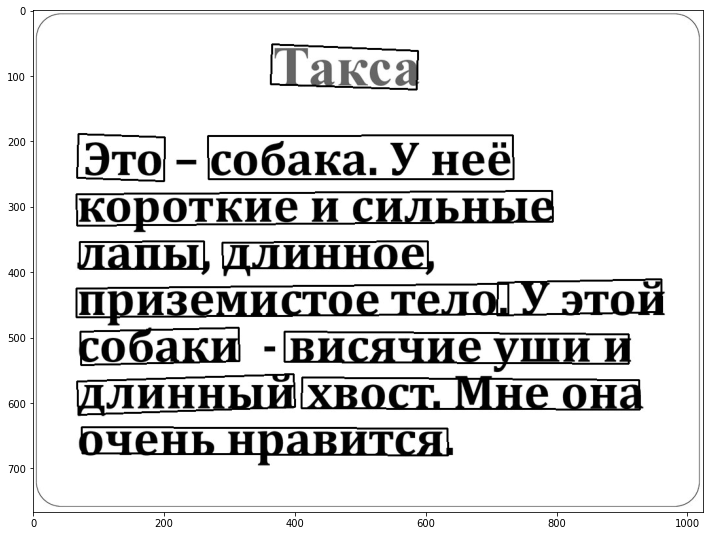

In [37]:
imshow(visualize_detection(img, polygons))